# SWB Prospect Theory Modeling 
Implement pyEM MAP parameter estimation method to estimate risk aversion, loss aversion, and inverse temp free parameters for every swb subject

In [1]:
import numpy as np
import random
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.optimize import minimize # minimize function is used for parameter recovery 
import seaborn as sns 
import tqdm
from scipy.stats import spearmanr
import statsmodels.api as sm
import os
from scipy.stats import norm
import pickle
import datetime



import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/scripts/')
import SWB_modeling_utils

sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/scripts/pyEM')
import pyEM.math, pyEM.fitting, pyEM.plotting

## Load data 

In [4]:
swb_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
behav_path = f'{swb_dir}behavior_analysis/behavior_preprocessed/'
# subj_list = pd.read_excel(f'{swb_dir}/data/subjects.xlsx', sheet_name='full_subj_test', usecols=[0],engine='openpyxl') #all average SWB subj 
subj_list = pd.read_excel(f'{swb_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0],engine='openpyxl') #SWB subj that meet all inclusion criteria
subj_ids = list(subj_list.PatientID)

date = datetime.date.today().strftime('%m%d%Y')

In [5]:
#loading behavior data as list of pandas dfs > need to input data as list of dfs into EMfit function
behav_list = []
for subj_id in subj_ids:
    df = pd.read_csv(f'{behav_path}{subj_id}_task_data')
    behav_list.append(df)

## SWB EM_MAP Functions

Risk aversion, loss aversion, and inverse temp free parameters require specific bounds. Before using these parameters to estimate the negative log likelihood, you must transform them from the gaussian space back into the native model space. Here, sigmoid functions are used in the form:

native_parameter_value = upper_bound / (1 + np.exp(-gaussian_parameter_value))

The upper bound for all free parameters was determined via simulation. Upper bounds for all parameters are tested with a fixed prior before performing full estimation. 

In [6]:
def norm2riskaversion(aversion_param):
    return 2 / (1 + np.exp(-aversion_param))

In [7]:
def norm2lossaversion(aversion_param):
    return 6 / (1 + np.exp(-aversion_param))

In [8]:
def norm2invtmp(invtemp):
    return 10 / (1 + np.exp(-invtemp))

In [9]:
def negll_base_pt_pyEM(params, subj_df, prior=None, output='npl'):

    risk_aversion, loss_aversion, inverse_temp = params
    
    risk_aversion = norm2riskaversion(risk_aversion) #transform parameter from gaussian space back into native model space using parameter-specific sigmoid function
    risk_aversion_bounds = [0.00001, 2] #set upper and lower bounds
    if risk_aversion< min(risk_aversion_bounds) or risk_aversion> max(risk_aversion_bounds): #prevent estimation from parameter values outside of bounds 
        return 10000000
    
    loss_aversion = norm2lossaversion(loss_aversion) #transform parameter from gaussian space back into native model space using parameter-specific sigmoid function
    loss_aversion_bounds = [0.00001, 6] #set upper and lower bounds
    if loss_aversion< min(loss_aversion_bounds) or loss_aversion> max(loss_aversion_bounds):  #prevent estimation from parameter values outside of bounds 
        return 10000000
    
    inverse_temp = norm2invtmp(inverse_temp) #transform parameter from gaussian space back into native model space using parameter-specific sigmoid function
    this_beta_bounds = [0.00001, 10]  #set upper and lower bounds
    if inverse_temp < min(this_beta_bounds) or inverse_temp > max(this_beta_bounds):  #prevent estimation from parameter values outside of bounds 
        return 10000000

    #Initialize choice probability vector to calculate negative log likelihood
    choice_prob_list = []
    choice_list = []

    #Initialize empty data vectors to return all relevant data if output = 'all'
    tr          = []
    trial_list  = []
    util_g      = []
    util_s      = []
    choice_util = []
    p_g         = []
    p_s         = []
    safe        = []
    high        = []
    low         = []
    w_safe      = []
    w_high      = []
    w_low       = []

    for trial in range(len(subj_df)):

        trial_info = subj_df.iloc[trial]
        trial_type = trial_info['TrialType']
        choice = trial_info['GambleChoice']
        high_bet = trial_info['HighBet']
        low_bet = trial_info['LowBet']
        safe_bet = trial_info['SafeBet']


        #store trial info 
        choice_list.append(choice)
        tr.append(trial)
        trial_list.append(trial_type)
        high.append(high_bet)
        low.append(low_bet)
        safe.append(safe_bet)

        ##### Utility calculations #####

        # transform to high bet value to utility (gamble)
        if high_bet > 0: #mix or gain trials
            weighted_high_bet = 0.5 * ((high_bet)**risk_aversion)
        else: #loss trials
            weighted_high_bet = 0 
        
        w_high.append(weighted_high_bet)

        # transform to low bet value to utility (gamble)
        if low_bet < 0: #loss and mix trials
            weighted_low_bet = -0.5 * loss_aversion * ((-low_bet)**risk_aversion)
            
        else: #gain trials
            weighted_low_bet = 0 
        
        w_low.append(weighted_low_bet)
        
        util_gamble = weighted_high_bet + weighted_low_bet
        util_g.append(util_gamble)
      

        # transform safe bet value to utility (safe)
        if safe_bet >= 0: #gain or mix trials
            util_safe = (safe_bet)**risk_aversion
        else: #loss trials
            util_safe = -loss_aversion * ((-safe_bet)**risk_aversion)

        w_safe.append(util_safe)
        util_s.append(util_safe)


        ##### Choice probability calculation #####

        # convert EV to choice probabilities via softmax
        p_gamble = np.exp(inverse_temp*util_gamble) / ( np.exp(inverse_temp*util_gamble) + np.exp(inverse_temp*util_safe) )
        p_safe = np.exp(inverse_temp*util_safe) / ( np.exp(inverse_temp*util_gamble) + np.exp(inverse_temp*util_safe) )
        # p_safe = 1-p_gamble
        p_g.append(p_gamble)
        p_s.append(p_safe)

        # append probability of chosen options
        if choice == 'gamble':
            choice_prob_list.append(p_gamble)
            choice_util.append(util_gamble)

        elif choice == 'safe':
            choice_prob_list.append(p_safe)
            choice_util.append(p_safe)

    # calculate negative log likelihood of choice probabilities 
            
    negll = -np.sum(np.log(choice_prob_list))
    
    if np.isnan(negll):
        negll = np.inf
    
    if output == 'npl':
        if prior is not None:  # EM-fit: P(Choices | h) * P(h | O) should be maximised, therefore same as minimizing it with negative sign
            fval = -(-negll + prior['logpdf'](params))

            if any(prior['sigma'] == 0):
                this_mu = prior['mu']
                this_sigma = prior['sigma']
                this_logprior = prior['logpdf'](params)
                print(f'mu: {this_mu}')
                print(f'sigma: {this_sigma}')
                print(f'logpdf: {this_logprior}')
                print(f'fval: {fval}')
            
            if np.isinf(fval): 
                fval = 10000000
            return fval
        else: # NLL fit 
            return negll
        
    elif output == 'all': #WHATEVER YOU WANT TO OUTPUT IF NOT OPTIMIZING
        subj_dict = {'params'      : [risk_aversion, loss_aversion, inverse_temp],
                     'tr'          : tr,
                     'TrialType'   : trial_list,
                     'GambleChoice':choice_list,
                     'ChoiceProb'  : choice_prob_list,
                     'ChoiceUtil'  : choice_util,
                     'util_gamble' : util_g,
                     'util_safe'   : util_s, 
                     'p_gamble'    : p_g,
                     'p_safe'      : p_s,
                     'HighBet'     : high,
                     'LowBet'      : low,
                     'SafeBet'     : safe,
                     'WeightedHigh': w_high,
                     'WeightedLow' : w_low,
                     'WeightedSafe': w_safe,
                     'negll'       : negll,
                     'bic'         : len(params) * np.log(150) + 2*negll}
        
        return subj_dict

#### Testing PT function negative log likelihood calculation with fixed prior
Risk upper bound = 2
Loss upper bound = 6
InvTemp upper bound = 10

In [10]:
#set fixed prior for function testing  
param_names = ['risk_aversion','loss_aversion','inverse_temp']
nparams = len(param_names)
prior= {}
prior['mu']    = np.abs(0.1 * np.random.randn(nparams, 1)) #random means for prior distribution in gaussian space 
prior['sigma'] = np.full((nparams, 1), 100) # prior dist std
prior['logpdf'] = lambda x: np.sum(norm.logpdf(x, prior['mu'],np.sqrt(prior['sigma']))) #calculates separate normpdfs per parameter and sums their logs


In [11]:
#testing negll function & finding maximum parameter bounds - make sure none of the negll values = 10000000

#set params to desired upper bound 
params = np.array([2,6,10]) #risk, loss, invtemp
negll_list = []

for s in range(len(subj_ids)):
    df = behav_list[s]
    negll = negll_base_pt_pyEM(params, df,prior=prior, output='npl')
    negll_list.append(negll)
    print(subj_ids[s],negll)

DA8 194.47755993698848
DA9 736.5588324637038
DA10 880.0320003706559
DA11 1488.1420607128089
DA023 839.0756930117354
DA026 1167.7696317874945
MS002 857.7740624108451
MS003 1700.1433737997863
MS004 1232.2878383594807
MS016 1330.7864698035655
MS017 516.2245015149458
MS019 2316.8899954845106
MS020 1098.171863564501
MS022 1362.8643375058255
MS025 595.2240614923414
MS026 572.6141846390543
MS027 1192.832747150142
MS029 1531.1448943431021
MS030 1255.1869088075987
MS033 1035.8198048858378
MS035 1370.025534731693


## Parameter Estimation with MAP using pyEM 

In [12]:
#run pyEM on all subjects 

param_names = ['risk_aversion','loss_aversion','inverse_temp']
m, inv_h, posterior, NPL, NLPrior, NLL = pyEM.fitting.EMfit(behav_list, negll_base_pt_pyEM, param_names)

#reorganize and rename outputs!

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Extract parameter estimates 

In [13]:
#transform gaussian params into native model space (using sigmoid function)

param_names = ['risk_aversion','loss_aversion','inverse_temp']
nparams = len(param_names)

#extract estimated parameter values in gaussian space  
est_params = m.T.copy() #rows = subj, cols = params


for subj_idx in range(len(subj_ids)): #iterate through each subject

    for param_idx, param_name in enumerate(param_names): #iterate through each free parameter 
        if 'risk_aversion' == param_name:
            est_params[subj_idx, param_idx] = norm2riskaversion(m[param_idx, subj_idx]) #replace gaussian value with transformed value in param matrix 
        elif 'loss_aversion' == param_name:
            est_params[subj_idx, param_idx] = norm2lossaversion(m[param_idx, subj_idx]) #replace gaussian value with transformed value in param matrix 
        elif 'inverse_temp' == param_name: 
            est_params[subj_idx, param_idx] = norm2invtmp(m[param_idx, subj_idx]) #replace gaussian value with transformed value in param matrix 

est_params #each row is the 3 param estimates for each subj 
# can also make this a dataframe next time 

array([[1.16158991, 3.66623052, 3.54182183],
       [1.33460417, 0.81894006, 3.69606033],
       [0.79543666, 1.65977137, 3.19641572],
       [1.00075201, 0.42914897, 2.29793964],
       [0.96570182, 1.69301416, 2.52166657],
       [0.5909562 , 1.87042571, 3.03743572],
       [0.80576676, 2.29580748, 2.38746537],
       [0.75994437, 0.128203  , 4.76984558],
       [0.6916624 , 1.80303998, 1.62659318],
       [0.64571028, 1.00150661, 5.24406421],
       [1.31050198, 1.03344057, 5.44867522],
       [1.08592339, 0.05499976, 5.38975638],
       [0.61980469, 2.13360257, 2.04696103],
       [1.25623593, 0.25953408, 4.40828603],
       [0.80748902, 3.84733281, 1.86473773],
       [1.26959392, 1.56700488, 2.59642662],
       [0.67262596, 0.65775917, 4.59393726],
       [0.56264176, 0.66196133, 2.40730858],
       [0.76399898, 1.15705695, 4.55990705],
       [1.43754892, 0.39788339, 5.38243636],
       [1.01818509, 0.73096155, 2.18444437]])

In [14]:
# compute mean, std of posterior distributions & covariance matrix from inv hessians (just non-diag elements of inv hessian for all param combos)
posterior_mu, posterior_std, _, covariance_mat = pyEM.math.compGauss_ms(m,inv_h,2) #posterior mu/std is same here as in EMfit output 

covariance_mat #covariance between free parameters 

array([[ 0.38765166, -0.1679754 ,  0.08244552],
       [-0.1679754 ,  1.7318962 , -0.46393361],
       [ 0.08244552, -0.46393361,  0.52099235]])

In [15]:
#combine results into dictionary to save 
swb_pt_MAP_dict = {}

swb_pt_MAP_dict['subj_ids'] = subj_ids
swb_pt_MAP_dict['gauss_params'] = m
swb_pt_MAP_dict['params'] = est_params
swb_pt_MAP_dict['param_names'] = param_names
swb_pt_MAP_dict['inverse_hess'] = inv_h
swb_pt_MAP_dict['gauss_posterior_mu'] = posterior['mu']
swb_pt_MAP_dict['gauss_posterior_std'] = posterior['sigma']
swb_pt_MAP_dict['gauss_covariance_mat'] = covariance_mat
swb_pt_MAP_dict['npl'] = NPL #negative joint posterior likelihood (current convergence criteria)
swb_pt_MAP_dict['NLPrior'] = NLPrior #negative log prior estimate
swb_pt_MAP_dict['nll'] =  NPL - NLPrior #negative log likelihood (neg joint posterior ll - neg log prior)
swb_pt_MAP_dict['bic'] =  np.log(150)*nparams + 2*swb_pt_MAP_dict['nll'] 
swb_pt_MAP_dict['aic'] =  2*nparams + 2*swb_pt_MAP_dict['nll'] 
swb_pt_MAP_dict['lme'] = [] #not calculated yet - convergence type = npl instead 

# swb_pt_MAP_dict

In [16]:
# Use parameter estimations to fit pt model to subjects and save data dicts --- remember to use gaussian form of vars!  est_params[subj_idx,:]
swb_pt_MAP_fit_subj_dicts = {}

for subj_idx in range(len(subj_ids)):
    params = m[:,subj_idx] #make sure these are the gaussian parameter values 
    df = behav_list[subj_idx]
    subj_dict = negll_base_pt_pyEM(params, df, prior=None, output='all')
    swb_pt_MAP_fit_subj_dicts[subj_ids[subj_idx]] = subj_dict

# swb_pt_MAP_fit_subj_dicts

In [17]:
#### save estimation dict 
save_dir = f'{swb_dir}swb_computational_modeling/swb_behav_models/data/swb_pt_subj_fits/'
os.makedirs(save_dir,exist_ok = True) 
date = datetime.date.today().strftime('%m%d%Y')

# create a binary pickle file 
f = open(f'{save_dir}swb_pt_EMMAP_dict_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(swb_pt_MAP_dict,f)
# # close file
f.close()

# create a binary pickle file 
f = open(f'{save_dir}swb_pt_EMMAP_fit_subj_dicts_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(swb_pt_MAP_fit_subj_dicts,f)
# # close file
f.close()


## Explore parameters
From Shawn 
- use spearman correlation instead of pearson because parameters are not gaussian! 
- Possible risk aversion x loss aversion interaction effect on BDI?
- *** will have to change negative log likelihood for calculating counterfactual utility!!!

In [18]:
#### create fig saving directory
fig_dir = f'{swb_dir}swb_computational_modeling/figs/swb_pt_MAP_fits/'
os.makedirs(fig_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y') #add date to file name --- update every run!


%matplotlib inline

#### set theme for all plots
sns.set_theme(style='ticks',font='Arial') 
sns.set_context("talk")

In [20]:
### load pickle dicts
save_dir = f'{swb_dir}swb_computational_modeling/swb_behav_models/data/swb_pt_subj_fits/'
swb_pt_MAP_fit_subj_dicts = pickle.load(open(f'{save_dir}swb_pt_EMMAP_fit_subj_dicts_01142024.pkl', 'rb' ) )


In [21]:
# extract estimated params for all subj
risk_est    = []
loss_est    = []
invtemp_est = []


for subj_id in subj_ids: 
    subj_data = swb_pt_MAP_fit_subj_dicts[subj_id]
    risk_est.append(subj_data['params'][0])
    loss_est.append(subj_data['params'][1])
    invtemp_est.append(subj_data['params'][2])


# risk_est = est_params[:,0]
# loss_est = est_params[:,1]
# invtemp_est = est_params[:,2]

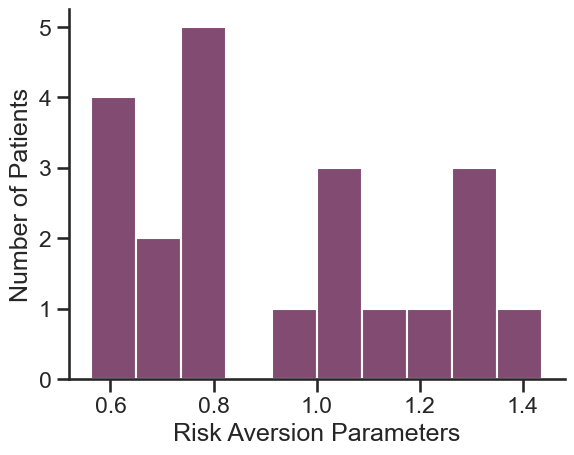

In [22]:
#### histogram of risk aversion parameter values 

# Create a histogram
fig, ax = plt.subplots()
sns.histplot(data=risk_est, color = '#580F41',bins=10)

# Set the xlabel and ylabel properties of the axes object
ax.set_xlabel('Risk Aversion Parameters')
ax.set_ylabel("Number of Patients")
sns.despine()


plt.savefig(f'{fig_dir}risk_aversion_MAP_estimates_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

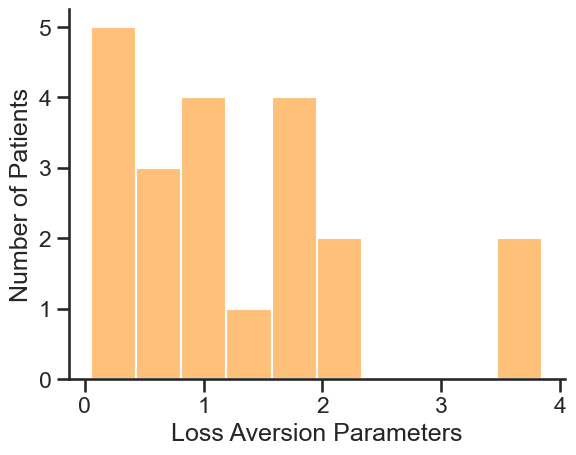

In [23]:
#### histogram of loss aversion parameter values 

# Create a histogram
fig, ax = plt.subplots()
sns.histplot(data=loss_est, color = '#ffac4d',bins=10)

# Set the xlabel and ylabel properties of the axes object
plt.xlabel('Loss Aversion Parameters')
ax.set_ylabel("Number of Patients")
sns.despine()


plt.savefig(f'{fig_dir}loss_aversion_MAP_estimates_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 



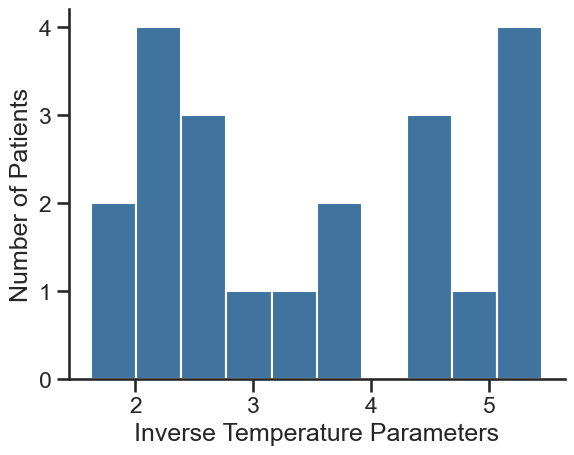

In [24]:
#### histogram of inv temp parameter values 

# Create a histogram
fig, ax = plt.subplots()
sns.histplot(data=invtemp_est, color = '#00467e',bins=10)

# Set the xlabel and ylabel properties of the axes object
plt.xlabel('Inverse Temperature Parameters')
ax.set_ylabel("Number of Patients")
sns.despine()


plt.savefig(f'{fig_dir}inverse_temperature_MAP_estimates_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


### Parameter x BDI correlations


In [25]:
### Test SWB BDI

#get swb bdi and bai 
raw_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_raw/'
subj_bdi = []
for subj_id in subj_ids:
    raw_data_dir = f'{raw_dir}{subj_id}/'
    raw_data_files = os.listdir(raw_data_dir)
    #load task data
    #load swb bdi and bai info to add to mood df
    raw_bdi_name = [x for x in raw_data_files if 'BDI' in x] #not all subj have BDI
    if raw_bdi_name:
        raw_bdi = pd.read_table(raw_data_dir+raw_bdi_name[0]) 
        bdi = raw_bdi['BDI Score'].iloc[-1]   
    else:
        bdi = 0
    subj_bdi.append(bdi)

# subj_bdi


In [26]:
subj_bdi_param_info = list(zip(subj_ids,subj_bdi,risk_est,loss_est,invtemp_est))
subj_bdi_param_info

[('DA8', 13, 1.1615899126811229, 3.666230519384663, 3.541821831089546),
 ('DA9', 32, 1.3346041741218522, 0.8189400604409541, 3.6960603296502073),
 ('DA10', 11, 0.7954366627938173, 1.659771366571093, 3.1964157202704553),
 ('DA11', 41, 1.000752006380309, 0.42914897030630345, 2.297939637566036),
 ('DA023', 14, 0.9657018154762024, 1.6930141552892441, 2.521666568724783),
 ('DA026', 19, 0.5909561973654198, 1.8704257146402306, 3.0374357170633064),
 ('MS002', 14, 0.8057667552604079, 2.2958074805920217, 2.387465366561096),
 ('MS003', 8, 0.7599443679572214, 0.12820299519457756, 4.769845582004077),
 ('MS004', 7, 0.6916623987792918, 1.8030399813327285, 1.6265931830521152),
 ('MS016', 10, 0.6457102785731033, 1.0015066068318872, 5.24406421336269),
 ('MS017', 26, 1.3105019773616013, 1.0334405699924836, 5.448675219297329),
 ('MS019', 12, 1.0859233922979272, 0.054999763709655244, 5.38975638248751),
 ('MS020', 6, 0.6198046861512775, 2.133602572007333, 2.0469610281878046),
 ('MS022', 10, 1.25623593490526

In [27]:
highbdi_subj_param_info = []
lowbdi_subj_param_info = []

highbdis = []
lowbdis = []

highbdi_risk = []
lowbdi_risk = []

highbdi_loss = []
lowbdi_loss = []

highbdi_invtemp = []
lowbdi_invtemp = []

for s in range(len(subj_ids)):
    info = subj_bdi_param_info[s]
    bdi = info[1]
    if bdi >= 20:
        highbdi_subj_param_info.append(info)
        highbdis.append(bdi)
        highbdi_risk.append(info[2])
        highbdi_loss.append(info[3])
        highbdi_invtemp.append(info[4])
    else:
        lowbdi_subj_param_info.append(info)
        lowbdis.append(bdi)
        lowbdi_risk.append(info[2])
        lowbdi_loss.append(info[3])
        lowbdi_invtemp.append(info[4])


In [28]:
risk_corr, risk_p = spearmanr(subj_bdi,risk_est)
print('Spearman correlation: %.3f' % risk_corr)
print(risk_p)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Spearman correlation: 0.248
0.2784601812078815


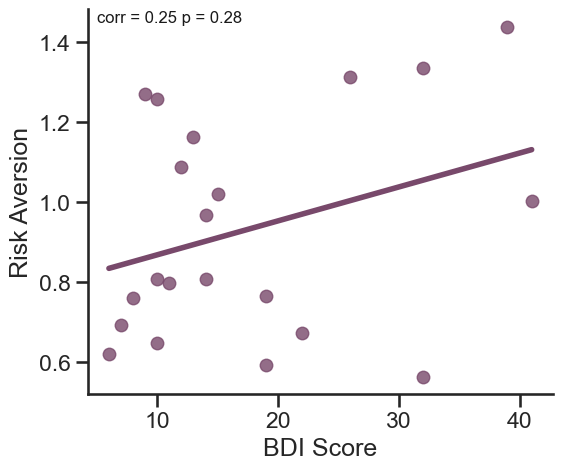

In [29]:
# plt.scatter(subj_bdi,risk_est,color = '#78496b')
fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=subj_bdi, y=risk_est,color = '#78496b',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(5, 1.45,f'corr = {np.round(risk_corr,2)} p = {np.round(risk_p,2)}',fontsize=12,color = 'k')
plt.xlabel('BDI Score')
plt.ylabel('Risk Aversion')
sns.despine()


plt.savefig(f'{fig_dir}risk_aversion_MAP_bdi_corr_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [30]:
loss_corr, loss_p = spearmanr(subj_bdi,loss_est)
print('Spearman correlation: %.3f' % loss_corr)
print(loss_p)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Spearman correlation: -0.297
0.19039720101939303


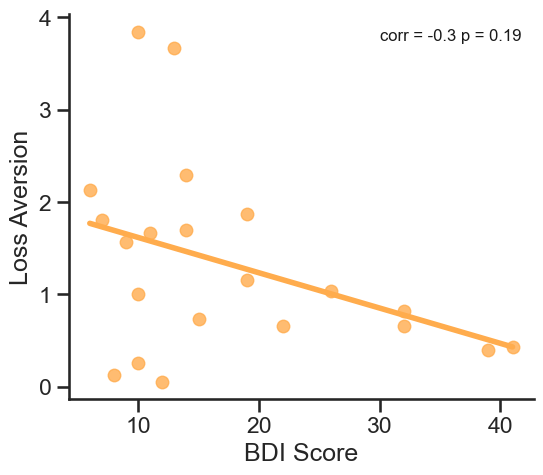

In [31]:
# plt.scatter(subj_bdi,loss_est,color = '#ffac4d')
fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=subj_bdi, y=loss_est,color = '#ffac4d',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(30, 3.75,f'corr = {np.round(loss_corr,2)} p = {np.round(loss_p,2)}',fontsize=12,color = 'k')
plt.xlabel('BDI Score')
plt.ylabel('Loss Aversion')
sns.despine()


plt.savefig(f'{fig_dir}loss_aversion_MAP_bdi_corr_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [33]:
invtemp_corr, invtemp_p = spearmanr(subj_bdi,invtemp_est)
print('Spearman correlation: %.3f' % invtemp_corr)
print(invtemp_p)

Spearman correlation: 0.243Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

0.2890028808413881


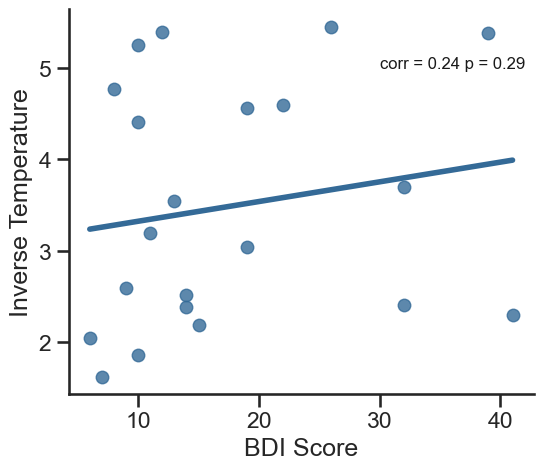

In [34]:
# plt.scatter(subj_bdi,invtemp_est,color = '#346a97')
fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=subj_bdi, y=invtemp_est,color = '#346a97',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(30, 5,f'corr = {np.round(invtemp_corr,2)} p = {np.round(invtemp_p,2)}',fontsize=12,color = 'k')
plt.xlabel('BDI Score')
plt.ylabel('Inverse Temperature')
sns.despine()



plt.savefig(f'{fig_dir}invtemp_MAP_bdi_corr_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None)

## Model Evaluation 

In [35]:

goodHessian = np.zeros(len(subj_ids))
modelID = 'negll_base_pt_pyEM'
modout = {}
modout[modelID] = {}
modout[modelID]['fit'] = {}
for subj_idx in range(len(subj_ids)):
    try:
        det_inv_hessian = np.linalg.det(inv_h[:, :, subj_idx])
        hHere = np.linalg.slogdet(inv_h[:, :, subj_idx])[1]
        L = -NPL - 0.5 * np.log(1 / det_inv_hessian) + (nparams / 2) * np.log(2 * np.pi)
        goodHessian[subj_idx] = 1
    except:
        print('Hessian is not positive definite')
        try:
            hHere = np.linalg.slogdet(inv_h[:,:,subj_idx])[1]
            L = np.nan
            goodHessian[subj_idx] = 0
        except:
            print('could not calculate')
            goodHessian[subj_idx] = -1
            L = np.nan
    modout[modelID]['fit']['lme'] = L
    modout[modelID]['fit']['goodHessian'] = goodHessian

np.sum(modout[modelID]['fit']['goodHessian']==1)


21

In [ ]:
#### Model Evaluation - Laplace Approximation (Bayes Factor similar to BIC that accounts for prior distribution, covariance from hessians, and paramater number)

# from mfit_optimize_hierarchical.m from Sam Gershman
# Also reference Daw 2009 (Equation 17) for Laplace approximation

# goodHessian = np.zeros(len(subj_ids))
# modelID = 'negll_base_pt_pyEM'
# modout = {}
# modout[modelID] = {}
# modout[modelID]['fit'] = {}
# for subj_idx in range(len(subj_ids)):
#     try:
#         det_inv_hessian = np.linalg.det(inv_h[:, :, subj_idx])
#         hHere = np.linalg.slogdet(inv_h[:, :, subj_idx])[1]
#         L = -NPL - 0.5 * np.log(1 / det_inv_hessian) + (nparams / 2) * np.log(2 * np.pi)
#         goodHessian[subj_idx] = 1
#     except:
#         print('Hessian is not positive definite')
#         try:
#             hHere = np.linalg.slogdet(inv_h[:,:,subj_idx])[1]
#             L = np.nan
#             goodHessian[subj_idx] = 0
#         except:
#             print('could not calculate')
#             goodHessian[subj_idx] = -1
#             L = np.nan
#     modout[modelID]['fit']['lme'] = L
#     modout[modelID]['fit']['goodHessian'] = goodHessian

#np.sum(modout[modelID]['fit']['goodHessian']==1)


# goodHessian = np.zeros(len(subj_ids))
# modelID = 'negll_base_pt_pyEM'
# modout = {}
# modout[modelID] = {}
# modout[modelID]['fit'] = {}
# for subj_idx in range(len(subj_ids)):
#     try:
#         det_inv_hessian = np.linalg.det(inv_h[:, :, subj_idx])
#         hHere = np.linalg.slogdet(inv_h[:, :, subj_idx])[1]
#         L = -NPL - 0.5 * np.log(1 / det_inv_hessian) + (nparams / 2) * np.log(2 * np.pi)
#         goodHessian[subj_idx] = 1
#     except:
#         print('Hessian is not positive definite')
#         try:
#             hHere = np.linalg.slogdet(inv_h[:,:,subj_idx])[1]
#             L = np.nan
#             goodHessian[subj_idx] = 0
#         except:
#             print('could not calculate')
#             goodHessian[subj_idx] = -1
#             L = np.nan
#     modout[modelID]['fit']['lme'] = L
#     modout[modelID]['fit']['goodHessian'] = goodHessian


# Make sure you know if BIC is positive or negative! and replace lme with
# bic if covariance is negative.
# Error check that BICs are in a similar range

In [ ]:
############### code from shawn bayesian model selection    "integrated BIC" 
#here, the mean and variance from a hierarchical model fit are use to generate 2000 samples of paramters, but you can still use the mean and variance from the individual fits in your data. fit.beh is just the behavioral data for all subjects. fit.objfunc is the function for outputing the negll

#https://www.nature.com/articles/s41467-020-17343-w

# Nsample     = 2000

# % info for normpdf, and flip if it is the wrong orientation
# mu          = mroot.(modelID).gauss.mu;            if size(mu,2)>size(mu,1),                 mu = mu'; end
# sigmasqrt   = sqrt(mroot.(modelID).gauss.sigma);   if size(sigmasqrt,2)>size(sigmasqrt,1),   sigmasqrt = sigmasqrt'; end

# % collect integrated nll
# iLog        = nan(numel(fit.beh),1); 

# % 1)get integrated nll by sampling nll from group gaussian
# fprintf([modelID ' - BICint: ']);
# for is = 1:numel(fit.beh)
   
#    subnll = nan(1,Nsample);
#    Gsamples    = normrnd(repmat(mu,1,Nsample),repmat(sigmasqrt,1,Nsample));  % samples from gaussian distribution found during EM; draw anew for each subject

#    % for each subject, get NLL for input params from gaussian
#    for k=1:Nsample
#       subnll(k)  = fit.objfunc(fit.beh{is},Gsamples(:,k)); 
#    end
#    fprintf([ num2str(is) ',']);
#    iLog(is) = log(sum(exp(-subnll))/Nsample);
# end

# % 2) Compute BICint
# bicint  = -2*sum(iLog)   + fit.npar*log(sum(fit.ntrials)); 